In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split,StratifiedKFold,StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import joblib 
import time
from imblearn.under_sampling import RandomUnderSampler 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write 

/kaggle/input/datosreales/DatosReales.csv
/kaggle/input/datasetheartdisease/dataset.csv


# Visualización inicial de los datos

In [2]:
data=pd.read_csv("/kaggle/input/datasetheartdisease/dataset.csv")
df=data.copy()
df=df.drop(["Unnamed: 0"],axis=1)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,8,17,1,1,5,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,8,22,0,1,5,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,9,19,1,1,3,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,8,21,0,0,4,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,8,14,0,1,5,8.0,0,0,0


# Separamos los datos
Separamos los datos de nuestro dataset, ponemos las características que vamos a utilizar para entrenar en la variable X y la variable a predecir en la varibale Y.

In [3]:
X=df.iloc[:,1:17]
Y=df.iloc[:,0]

# Estandarización de los datos
Usamos StandardScaler para estandarizar las caracteríticas que vamos a usar para entrenar en nuestro modelo.

In [4]:
scaler=StandardScaler()
columns=X.columns
s=scaler.fit_transform(X)

X=pd.DataFrame(s,columns=columns)
X.head(5)

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,-1.844750,1.193474,-0.27032,-0.198040,-0.046751,3.281069,-0.401578,-0.951711,0.136184,2.524911,0.538256,0.388307,-1.460354,2.541515,-0.195554,3.118419
1,-1.256338,-0.837890,-0.27032,5.049478,-0.424070,-0.490039,-0.401578,-0.951711,1.538806,-0.396054,0.538256,0.388307,-0.067601,-0.393466,-0.195554,-0.320675
2,-0.274603,1.193474,-0.27032,-0.198040,2.091388,3.281069,-0.401578,1.050739,0.697233,2.524911,0.538256,-1.529392,0.628776,2.541515,-0.195554,-0.320675
3,-0.647473,-0.837890,-0.27032,-0.198040,-0.424070,-0.490039,-0.401578,-0.951711,1.258282,-0.396054,-1.857852,-0.570542,-0.763977,-0.393466,-0.195554,3.118419
4,-0.726138,-0.837890,-0.27032,-0.198040,3.097572,-0.490039,2.490174,-0.951711,-0.705388,-0.396054,0.538256,0.388307,0.628776,-0.393466,-0.195554,-0.320675


# Submuestro de los datos con Undersampling

In [5]:
subsample=RandomUnderSampler()
X_new, Y_new=subsample.fit_resample(X,Y)
print("Dimensiones")
print("Xtrain_new: ", X_new.shape)
print("Ytrain_new: ", Y_new.shape)


Dimensiones
Xtrain_new:  (54746, 16)
Ytrain_new:  (54746,)


# Función Selección de características
Función utilizada para declarar Sequential Feature Selector con la cantidad de caracteristicas a selecciona y el modelo que va a utilizar

In [6]:
def select_features(model,n_features,fwd):
    sfs=SFS(
        model,
        k_features=n_features,
        forward=fwd,
        scoring='accuracy',
        cv=0
    )
    return sfs

# Selección de caracteríticas
Se declara la función train_select_features que lo que hace es por medio de StratifiedKFold y un array con la cantidad de caracteríticas a seleccionar, entrena un modelo y guardar el rendimiento en un dataframe para luego seleccionar con que y cuales caracteríticas tuvo mejor rendimieto el modelo.

In [7]:
def train_select_features(model,folds,features,X,Y):
    skf=StratifiedKFold(n_splits=folds)
    resultados=pd.DataFrame()
    idx=0
    resultados = {
        'Modelo': [],
        'Features':[],
        'Name Features':[],
        'Index Features':[],
        'Error':[],
        'Tiempo':[]
    }
    for feature in features:
        for train, test in skf.split(X=X,y=Y):
            tiempo_i = time.time()
            Xtrain, Xtest = X.iloc[train], X.iloc[test]
            Ytrain, Ytest = Y[train], Y[test]
            
            model_train=select_features(model,feature,False)
            model_train.fit(Xtrain,Ytrain)
            tiempo_f = time.time()
            resultados['Modelo'].append(str(model))
            resultados['Name Features'].append(model_train.k_feature_names_)
            resultados['Index Features'].append(model_train.k_feature_idx_)
            resultados['Features'].append(feature)
            resultados['Error'].append(1-model_train.k_score_)
            resultados['Tiempo'].append(tiempo_f-tiempo_i)



    return resultados

In [8]:
model=GradientBoostingClassifier(n_estimators=150,random_state=0)


In [9]:
features=[4,6,10,12]
resultados=train_select_features(model,5,features,X_new,Y_new)
resultados= pd.DataFrame.from_dict(resultados, orient='index')
resultados=resultados.transpose()
resultados

,Modelo,Features,Name Features,Index Features,Error,Tiempo
0,"GradientBoostingClassifier(n_estimators=150, r...",4,"(Stroke, Sex, AgeCategory, GenHealth)","(3, 7, 8, 11)",0.239976,630.348278
1,"GradientBoostingClassifier(n_estimators=150, r...",4,"(Stroke, Sex, AgeCategory, GenHealth)","(3, 7, 8, 11)",0.239514,608.058978
2,"GradientBoostingClassifier(n_estimators=150, r...",4,"(Stroke, Sex, AgeCategory, GenHealth)","(3, 7, 8, 11)",0.23972,594.610523
3,"GradientBoostingClassifier(n_estimators=150, r...",4,"(Stroke, Sex, AgeCategory, GenHealth)","(3, 7, 8, 11)",0.23892,624.448365
4,"GradientBoostingClassifier(n_estimators=150, r...",4,"(Stroke, Sex, AgeCategory, GenHealth)","(3, 7, 8, 11)",0.238304,622.233586
5,"GradientBoostingClassifier(n_estimators=150, r...",6,"(BMI, Stroke, Sex, AgeCategory, Diabetic, GenH...","(0, 3, 7, 8, 9, 11)",0.233377,600.833387
6,"GradientBoostingClassifier(n_estimators=150, r...",6,"(BMI, Stroke, Sex, AgeCategory, Diabetic, GenH...","(0, 3, 7, 8, 9, 11)",0.233463,574.538786
7,"GradientBoostingClassifier(n_estimators=150, r...",6,"(Smoking, Stroke, Sex, AgeCategory, Diabetic, ...","(1, 3, 7, 8, 9, 11)",0.234263,566.206243
8,"GradientBoostingClassifier(n_estimators=150, r...",6,"(BMI, Stroke, Sex, AgeCategory, Diabetic, GenH...","(0, 3, 7, 8, 9, 11)",0.232596,591.833849
9,"GradientBoostingClassifier(n_estimators=150, r...",6,"(Smoking, Stroke, Sex, AgeCategory, Diabetic, ...","(1, 3, 7, 8, 9, 11)",0.232915,594.522488


# Gráfica de los resultados obtenidos

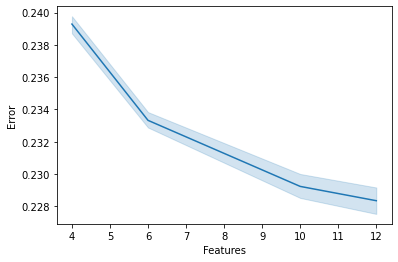

In [10]:
sns.lineplot(data=resultados,x="Features",y="Error")
plt.show()

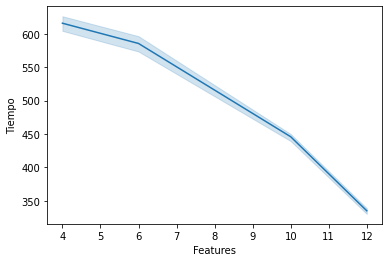

In [11]:
sns.lineplot(data=resultados,x="Features",y="Tiempo")
plt.show()

In [12]:
resultados.sort_values(by ='Error', ascending =True).head(10)

,Modelo,Features,Name Features,Index Features,Error,Tiempo
19,"GradientBoostingClassifier(n_estimators=150, r...",12,"(BMI, Smoking, Stroke, DiffWalking, Sex, AgeCa...","(0, 1, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15)",0.227207,336.778401
18,"GradientBoostingClassifier(n_estimators=150, r...",12,"(BMI, Smoking, AlcoholDrinking, Stroke, Sex, A...","(0, 1, 2, 3, 7, 8, 9, 11, 12, 13, 14, 15)",0.227732,337.877079
17,"GradientBoostingClassifier(n_estimators=150, r...",12,"(BMI, Smoking, Stroke, MentalHealth, DiffWalki...","(0, 1, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15)",0.227755,340.722582
14,"GradientBoostingClassifier(n_estimators=150, r...",10,"(BMI, Smoking, Stroke, Sex, AgeCategory, Diabe...","(0, 1, 3, 7, 8, 9, 11, 12, 14, 15)",0.228189,447.405137
13,"GradientBoostingClassifier(n_estimators=150, r...",10,"(BMI, Smoking, Stroke, Sex, AgeCategory, Diabe...","(0, 1, 3, 7, 8, 9, 11, 12, 13, 14)",0.228463,447.774426
12,"GradientBoostingClassifier(n_estimators=150, r...",10,"(BMI, Smoking, Stroke, MentalHealth, DiffWalki...","(0, 1, 3, 5, 6, 7, 8, 9, 11, 14)",0.229011,451.549591
16,"GradientBoostingClassifier(n_estimators=150, r...",12,"(BMI, Smoking, AlcoholDrinking, Stroke, DiffWa...","(0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 14, 15)",0.229285,327.070373
15,"GradientBoostingClassifier(n_estimators=150, r...",12,"(BMI, Smoking, AlcoholDrinking, Stroke, Physic...","(0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 14, 15)",0.229747,332.15756
10,"GradientBoostingClassifier(n_estimators=150, r...",10,"(BMI, Smoking, Stroke, PhysicalHealth, Sex, Ag...","(0, 1, 3, 4, 7, 8, 9, 11, 12, 14)",0.230021,449.35404
11,"GradientBoostingClassifier(n_estimators=150, r...",10,"(BMI, Smoking, AlcoholDrinking, Stroke, DiffWa...","(0, 1, 2, 3, 6, 7, 8, 9, 11, 15)",0.230472,433.248319


In [13]:
resultados.sort_values(by ='Tiempo', ascending =True).head(10)

,Modelo,Features,Name Features,Index Features,Error,Tiempo
16,"GradientBoostingClassifier(n_estimators=150, r...",12,"(BMI, Smoking, AlcoholDrinking, Stroke, DiffWa...","(0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 14, 15)",0.229285,327.070373
15,"GradientBoostingClassifier(n_estimators=150, r...",12,"(BMI, Smoking, AlcoholDrinking, Stroke, Physic...","(0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 14, 15)",0.229747,332.15756
19,"GradientBoostingClassifier(n_estimators=150, r...",12,"(BMI, Smoking, Stroke, DiffWalking, Sex, AgeCa...","(0, 1, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15)",0.227207,336.778401
18,"GradientBoostingClassifier(n_estimators=150, r...",12,"(BMI, Smoking, AlcoholDrinking, Stroke, Sex, A...","(0, 1, 2, 3, 7, 8, 9, 11, 12, 13, 14, 15)",0.227732,337.877079
17,"GradientBoostingClassifier(n_estimators=150, r...",12,"(BMI, Smoking, Stroke, MentalHealth, DiffWalki...","(0, 1, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15)",0.227755,340.722582
11,"GradientBoostingClassifier(n_estimators=150, r...",10,"(BMI, Smoking, AlcoholDrinking, Stroke, DiffWa...","(0, 1, 2, 3, 6, 7, 8, 9, 11, 15)",0.230472,433.248319
14,"GradientBoostingClassifier(n_estimators=150, r...",10,"(BMI, Smoking, Stroke, Sex, AgeCategory, Diabe...","(0, 1, 3, 7, 8, 9, 11, 12, 14, 15)",0.228189,447.405137
13,"GradientBoostingClassifier(n_estimators=150, r...",10,"(BMI, Smoking, Stroke, Sex, AgeCategory, Diabe...","(0, 1, 3, 7, 8, 9, 11, 12, 13, 14)",0.228463,447.774426
10,"GradientBoostingClassifier(n_estimators=150, r...",10,"(BMI, Smoking, Stroke, PhysicalHealth, Sex, Ag...","(0, 1, 3, 4, 7, 8, 9, 11, 12, 14)",0.230021,449.35404
12,"GradientBoostingClassifier(n_estimators=150, r...",10,"(BMI, Smoking, Stroke, MentalHealth, DiffWalki...","(0, 1, 3, 5, 6, 7, 8, 9, 11, 14)",0.229011,451.549591


# Función para el entrenamiento de los modelos

In [14]:
def entrenarModelo(model_train, Xtrain,Ytrain,Xtest,Ytest):
    model.fit(X=Xtrain,y=Ytrain)
    Ypred=model.predict(Xtest)

    print(f'Model: {str(model)}')
    print(f'Accuracy Score: {accuracy_score(Ytest,Ypred)}')
    print(f'Recall Score: {recall_score(Ytest,Ypred)}')
    print(f'F1-Score: {f1_score(Ytest,Ypred)}')
    cm = confusion_matrix(Ytest, Ypred, labels=model_train.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_train.classes_)
    disp.plot()
    return model_train

# Función para la validación del modelo con datos reales

In [15]:
def validarModelo(model, X, Y):
  y_pred=model.predict(X)
  print("Accuracy:",accuracy_score(Y, y_pred))
  print(f'Precission Score: {precision_score(Y,y_pred)}')
  print(f'Recall Score: {recall_score(Y,y_pred)}')
  print(f'F1-Score: {f1_score(Y,y_pred)}')
  cm = confusion_matrix(Y, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
  disp.plot()

# Función para seleccionar la data
Esta función se encarga de extraer del dataframe original las caracteríticas seleccionadas a través de sus índices, para luego entrenar el modelo solo con esas caracteríticas seleccionadas

In [16]:
def select_data(data,index):
    return data.iloc[:,index]

# Función para particionar los datos
Partimos los datos en train y test en una proporción 70-30. 70% de los datos para entrenar el modelo y 30% de los datos para la validación del mismo.

In [17]:
def split_data(X,Y):
    return train_test_split(X,Y,test_size=0.3,random_state=50)

# Cargamos los datos reales

In [18]:
data_real=pd.read_csv("/kaggle/input/datosreales/DatosReales.csv")
df_real=data_real.copy()
df_real["BMI"] = encoder.fit_transform(df_real["BMI"])
df_real.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,1,0,0,0,0,0,0,8,10,0,0,5,6,0,0,0
1,0,4,0,0,0,0,0,0,8,10,0,1,5,6,1,0,0
2,1,8,1,0,1,25,28,1,9,20,1,0,3,9,0,1,0
3,0,5,0,0,0,0,0,0,9,10,0,0,6,6,0,0,0
4,1,12,0,1,1,30,15,1,8,18,1,0,4,4,1,1,1


In [19]:
X_real=df_real.iloc[:,1:]
Y_real=df_real.iloc[:,0]

# Modelo con 4 características seleccionadas

In [20]:
selected_data=select_data(X_new,np.array(resultados["Index Features"][0]))
selected_data.head()

,Stroke,Sex,AgeCategory,GenHealth
0,-0.198040,1.050739,-0.144340,-0.570542
1,-0.198040,-0.951711,0.136184,1.347157
2,5.049478,1.050739,1.538806,-0.570542
3,-0.198040,1.050739,-0.985913,-0.570542
4,-0.198040,1.050739,-0.424864,0.388307


In [21]:
X_train,X_test,y_train,y_test=split_data(selected_data,Y_new)

Model: GradientBoostingClassifier(n_estimators=150, random_state=0)
Accuracy Score: 0.7606551388212373
Recall Score: 0.8087789499211835
F1-Score: 0.772393028776562


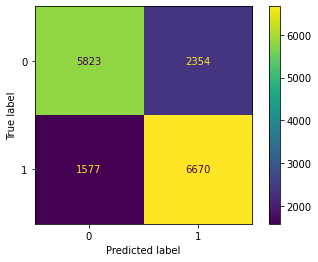

In [22]:
modelo_entrenado=entrenarModelo(model,X_train,y_train,X_test,y_test)


## Validación del modelo con datos reales

In [23]:
X_real_seleccionada=select_data(X_real,np.array(resultados["Index Features"][0]))

Accuracy: 0.4666666666666667
Precission Score: 0.4666666666666667
Recall Score: 1.0
F1-Score: 0.6363636363636364


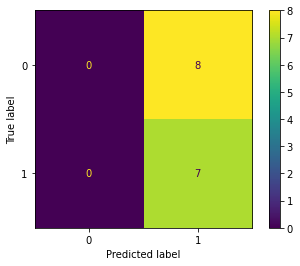

In [24]:
validarModelo(modelo_entrenado,X_real_seleccionada,Y_real)


# Modelo con 6 características seleccionadas


In [25]:
selected_data=select_data(X_new,np.array(resultados["Index Features"][5]))
selected_data.head()

,BMI,Stroke,Sex,AgeCategory,Diabetic,GenHealth
0,0.450686,-0.198040,1.050739,-0.144340,2.524911,-0.570542
1,-1.155647,-0.198040,-0.951711,0.136184,-0.396054,1.347157
2,1.457594,5.049478,1.050739,1.538806,-0.396054,-0.570542
3,-0.836269,-0.198040,1.050739,-0.985913,-0.396054,-0.570542
4,-0.402039,-0.198040,1.050739,-0.424864,-0.396054,0.388307


In [26]:
X_train,X_test,y_train,y_test=split_data(selected_data,Y_new)


Model: GradientBoostingClassifier(n_estimators=150, random_state=0)
Accuracy Score: 0.7638821237213833
Recall Score: 0.8064750818479447
F1-Score: 0.7742724097788126


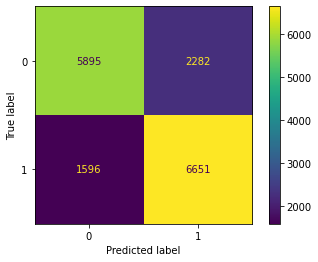

In [27]:
modelo_entrenado=entrenarModelo(model,X_train,y_train,X_test,y_test)


## Validación del modelo con datos reales

In [28]:
X_real_seleccionada=select_data(X_real,np.array(resultados["Index Features"][5]))


Accuracy: 0.4666666666666667
Precission Score: 0.4666666666666667
Recall Score: 1.0
F1-Score: 0.6363636363636364


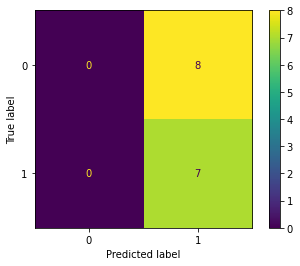

In [29]:
validarModelo(modelo_entrenado,X_real_seleccionada,Y_real)


# Modelo con 10 características seleccionadas

In [30]:
selected_data=select_data(X_new,np.array(resultados["Index Features"][10]))
selected_data.head()

,BMI,Smoking,Stroke,PhysicalHealth,Sex,AgeCategory,Diabetic,GenHealth,SleepTime,KidneyDisease
0,0.450686,-0.837890,-0.198040,-0.172524,1.050739,-0.144340,2.524911,-0.570542,-0.067601,-0.195554
1,-1.155647,-0.837890,-0.198040,-0.424070,-0.951711,0.136184,-0.396054,1.347157,-1.460354,-0.195554
2,1.457594,1.193474,5.049478,0.079022,1.050739,1.538806,-0.396054,-0.570542,2.021529,-0.195554
3,-0.836269,1.193474,-0.198040,2.091388,1.050739,-0.985913,-0.396054,-0.570542,-0.763977,-0.195554
4,-0.402039,1.193474,-0.198040,-0.424070,1.050739,-0.424864,-0.396054,0.388307,-0.067601,-0.195554


In [31]:
X_train,X_test,y_train,y_test=split_data(selected_data,Y_new)


Model: GradientBoostingClassifier(n_estimators=150, random_state=0)
Accuracy Score: 0.7696663419386264
Recall Score: 0.8064750818479447
F1-Score: 0.7785776997366112


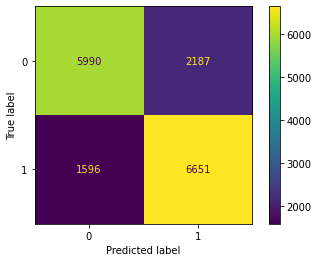

In [32]:
modelo_entrenado=entrenarModelo(model,X_train,y_train,X_test,y_test)


## Validación del modelo con datos reales

In [33]:
X_real_seleccionada=select_data(X_real,np.array(resultados["Index Features"][10]))

Accuracy: 0.4666666666666667
Precission Score: 0.4666666666666667
Recall Score: 1.0
F1-Score: 0.6363636363636364


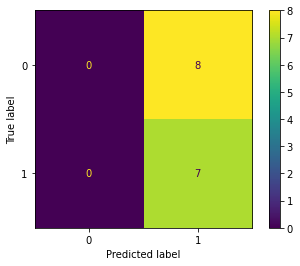

In [34]:
validarModelo(modelo_entrenado,X_real_seleccionada,Y_real)


# Modelo con 12 características seleccionadas

In [35]:
selected_data=select_data(X_new,np.array(resultados["Index Features"][15]))
selected_data.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,Sex,AgeCategory,Diabetic,GenHealth,SleepTime,KidneyDisease,SkinCancer
0,0.450686,-0.837890,-0.27032,-0.198040,-0.172524,1.050739,-0.144340,2.524911,-0.570542,-0.067601,-0.195554,-0.320675
1,-1.155647,-0.837890,-0.27032,-0.198040,-0.424070,-0.951711,0.136184,-0.396054,1.347157,-1.460354,-0.195554,-0.320675
2,1.457594,1.193474,-0.27032,5.049478,0.079022,1.050739,1.538806,-0.396054,-0.570542,2.021529,-0.195554,-0.320675
3,-0.836269,1.193474,-0.27032,-0.198040,2.091388,1.050739,-0.985913,-0.396054,-0.570542,-0.763977,-0.195554,-0.320675
4,-0.402039,1.193474,-0.27032,-0.198040,-0.424070,1.050739,-0.424864,-0.396054,0.388307,-0.067601,-0.195554,-0.320675


In [36]:
X_train,X_test,y_train,y_test=split_data(selected_data,Y_new)

Model: GradientBoostingClassifier(n_estimators=150, random_state=0)
Accuracy Score: 0.7703360935216756
Recall Score: 0.8050200072753728
F1-Score: 0.7787683284457477


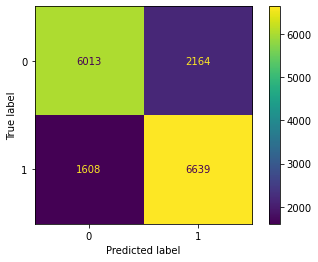

In [37]:
modelo_entrenado=entrenarModelo(model,X_train,y_train,X_test,y_test)


## Validación del modelo con datos reales

In [38]:
X_real_seleccionada=select_data(X_real,np.array(resultados["Index Features"][15]))


Accuracy: 0.4666666666666667
Precission Score: 0.4666666666666667
Recall Score: 1.0
F1-Score: 0.6363636363636364


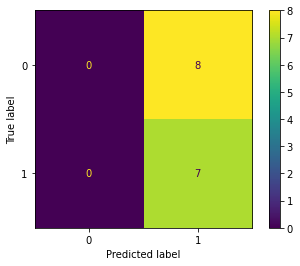

In [39]:
validarModelo(modelo_entrenado,X_real_seleccionada,Y_real)
